## Importation de librairie

In [72]:
import pandas as pd
import numpy as np
#import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob


import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
import plotly.express as px
from collections import Counter
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/vicky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vicky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vicky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vicky/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /home/vicky/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Affichage du train

In [73]:
df_train= pd.read_csv('train.tsv', sep='\t')
df_train.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

## Etude du fichier

In [74]:
# Aperçu des premières lignes du dataset
df_train.head()

# Obtenir des informations générales sur le dataset
df_train.info()

# Vérification des valeurs manquantes dans chaque colonne
df_train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64


/tmp/ipykernel_92217/1756630619.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




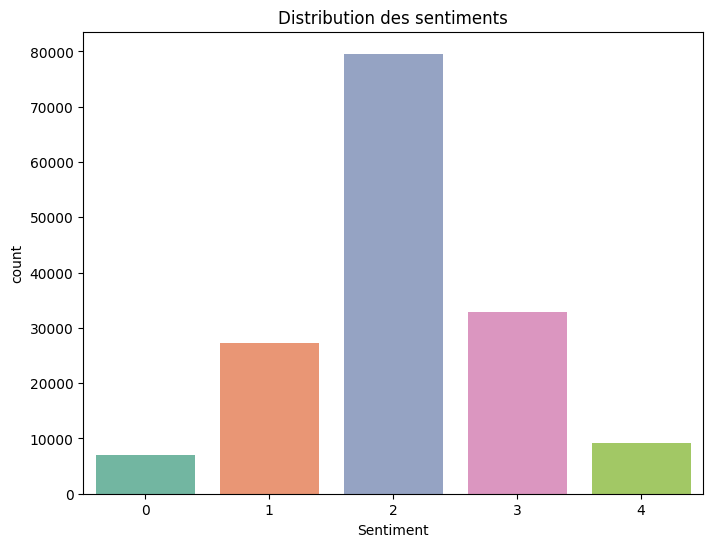

In [75]:
# Statistiques descriptives des colonnes numériques
df_train.describe()

# Distribution des étiquettes de sentiment
sentiment_distribution = df_train['Sentiment'].value_counts()
print(sentiment_distribution)

# Afficher visuellement la distribution des sentiments
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=df_train, palette='Set2')
plt.title('Distribution des sentiments')
plt.show()


In [76]:
from collections import Counter
from nltk.corpus import stopwords
import string

# Fonction de nettoyage pour enlever la ponctuation et les mots vides
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return words

# Appliquer le nettoyage sur la colonne 'Phrase'
df_train['Cleaned_Phrase'] = df_train['Phrase'].apply(clean_text)

# Compter les mots les plus fréquents
all_words = [word for phrase in df_train['Cleaned_Phrase'] for word in phrase]
word_freq = Counter(all_words).most_common(20)

# Afficher les mots les plus fréquents
print(word_freq)


[('film', 6689), ('movie', 5905), ('nt', 3970), ('one', 3609), ('like', 3071), ('story', 2520), ('rrb', 2438), ('lrb', 2098), ('good', 2043), ('characters', 1882), ('much', 1862), ('time', 1747), ('comedy', 1721), ('even', 1597), ('little', 1575), ('funny', 1522), ('way', 1511), ('life', 1484), ('make', 1396), ('movies', 1345)]


In [77]:
# Groupement des phrases par SentenceId
grouped_by_sentence = df_train.groupby('SentenceId')['Phrase'].apply(list)

# Afficher les 5 premiers groupes
grouped_by_sentence.head()


SentenceId
1    [A series of escapades demonstrating the adage...
2    [This quiet , introspective and entertaining i...
3    [Even fans of Ismail Merchant 's work , I susp...
4    [A positively thrilling combination of ethnogr...
5    [Aggressive self-glorification and a manipulat...
Name: Phrase, dtype: object

In [78]:
# Filtrer les phrases avec un sentiment très négatif (0) ou très positif (4)
extreme_sentiments = df_train[df_train['Sentiment'].isin([0, 4])]

# Afficher quelques phrases avec des sentiments extrêmes
print(extreme_sentiments[['Phrase', 'Sentiment']].sample(10))


                                                   Phrase  Sentiment
142383     been made with an enormous amount of affection          4
59643          A bad movie that happened to good actors .          0
115953                            a terrible movie , just          0
55226                            exceptionally well-acted          4
51897                              Visually captivating .          4
118711  has made a film so unabashedly hopeful that it...          4
136117                    especially grateful for freedom          4
66157   Lacks the spirit of the previous two , and mak...          0
90561   look smeary and blurry , to the point of distr...          0
14748   sets itself apart by forming a chain of relati...          4


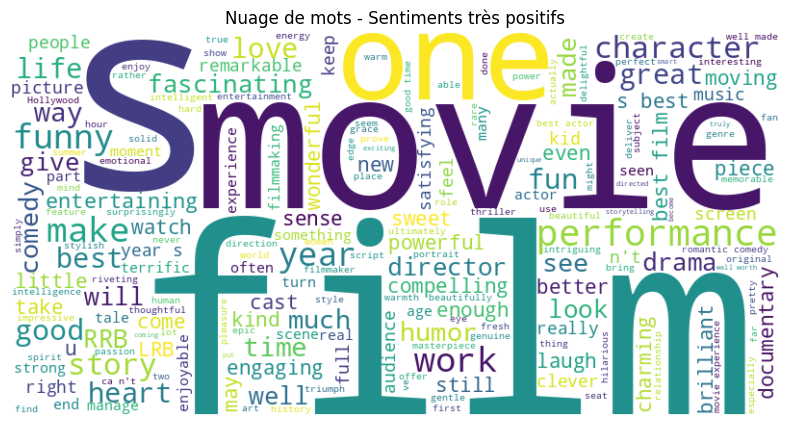

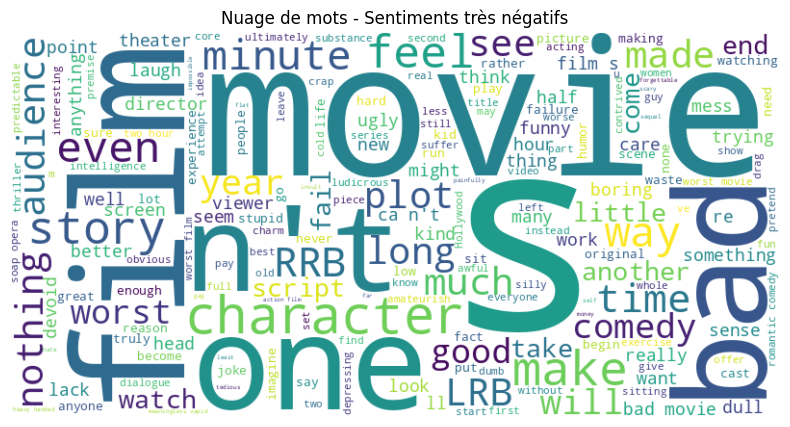

In [79]:
# Séparer les phrases positives et négatives
positive_phrases = ' '.join(df_train[df_train['Sentiment'] == 4]['Phrase'])
negative_phrases = ' '.join(df_train[df_train['Sentiment'] == 0]['Phrase'])

# Créer un nuage de mots pour les phrases positives
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_phrases)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Nuage de mots - Sentiments très positifs')
plt.axis('off')
plt.show()

# Créer un nuage de mots pour les phrases négatives
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_phrases)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Nuage de mots - Sentiments très négatifs')
plt.axis('off')
plt.show()


In [80]:
# Ajouter une nouvelle colonne qui compte le nombre de mots par phrase
df_train['Phrase_Length'] = df_train['Phrase'].apply(lambda x: len(x.split()))

# Trier les phrases par longueur (du plus court au plus long)
shortest_phrases = df_train.sort_values(by='Phrase_Length').head(10)

# Afficher les phrases les plus courtes
print(shortest_phrases[['Phrase', 'Phrase_Length', 'Sentiment']])


               Phrase  Phrase_Length  Sentiment
2005                               0          1
13                the              1          2
11      demonstrating              1          2
8           escapades              1          2
42497           Proof              1          2
156000     annoyances              1          2
37                  ,              1          2
36             gander              1          2
30               also              1          2
26              goose              1          2


In [81]:
# Grouper par SentenceId et obtenir plusieurs statistiques
grouped_stats = df_train.groupby('SentenceId').agg(
    num_phrases=('Phrase', 'count'),
    avg_phrase_length=('Phrase_Length', 'mean'),
    majority_sentiment=('Sentiment', lambda x: x.value_counts().idxmax())
)

# Afficher les 5 premières lignes
print(grouped_stats.head())


            num_phrases  avg_phrase_length  majority_sentiment
SentenceId                                                    
1                    63           5.571429                   2
2                    18           3.055556                   2
3                    35           3.714286                   2
4                    40           4.875000                   2
5                    10           2.900000                   1


In [82]:
sentence_id_1 = df_train[df_train['SentenceId'] == 1]
sentence_id_1

PhraseId  SentenceId                                             Phrase  \
0          1           1  A series of escapades demonstrating the adage ...   
1          2           1  A series of escapades demonstrating the adage ...   
2          3           1                                           A series   
3          4           1                                                  A   
4          5           1                                             series   
..       ...         ...                                                ...   
58        59           1                                               much   
59        60           1                                         of a story   
60        61           1                                            a story   
61        62           1                                              story   
62        63           1                                                  .   

    Sentiment                                     Cleaned_Phrase  \
0           1  [series, escapades, demonstrating, adage, good...   
1           2  [series, escapades, demonstrating, adage, good...   
2           2                                           [series]   
3           2                                                 []   
4           2                                           [series]   
..        ...                                                ...   
58          2                                             [much]   
59          2                                            [story]   
60          2                                            [story]   
61          2                                            [story]   
62          2                                                 []   

    Phrase_Length  
0              37  
1              14  
2               2  
3               1  
4               1  
..            ...  
58              1  
59              3  
60              2  
61              1  
62              1  

[63 rows x 6 columns]

In [83]:
duplicate_phrase_ids = df_train[df_train.duplicated(subset='PhraseId', keep=False)]
duplicate_phrase_ids

Empty DataFrame
Columns: [PhraseId, SentenceId, Phrase, Sentiment, Cleaned_Phrase, Phrase_Length]
Index: []

## Suppression des occurences SentenceId

In [84]:
def keep_first_occurrence(df, column_name):
    # Supprimer les doublons tout en gardant la première occurrence basée sur la colonne spécifiée
    filtered_df = df.drop_duplicates(subset=[column_name], keep='first')
    return filtered_df

# Appliquer la fonction à la colonne 'SentenceId'
filtered_data = keep_first_occurrence(df_train, 'SentenceId')

# Afficher les premières lignes du DataFrame résultant pour vérification
filtered_data

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  
0       [series, escapades, demonstrating, adage, good...             37  
63      [quiet, introspective, entertaining, independe...             11  
81      [even, fans, ismail, merchant, work, suspect, ...             21  
116     [positively, thrilling, combination, ethnograp...             26  
156     [aggressive, selfglorification, manipulative, ...              7  
...                                                   ...            ...  
155984     [either, willing, go, claustrophobic, concept]             16  
155997  [despite, annoyances, capable, clayburgh, tamb...             26  
156021  [lrb, tries, rrb, parody, genre, already, joke...             17  
156031   [movie, downfall, substitute, plot, personality]             11  
156039  [film, darkly, atmospheric, herrmann, quietly,...             21  

[8529 rows x 6 columns]

## Detecter les différentes langues

In [85]:
from langdetect import detect
import pandas as pd

def detecter_langues(df, colonne_texte):
    """
    Détecte les langues dans une colonne de texte.
    Ajoute une colonne 'langue_detectee' au DataFrame indiquant la langue de chaque phrase.
    Affiche les langues détectées et le nombre de lignes par langue.
    Retourne le DataFrame avec la colonne des langues détectées.
    """
    langues_detectees = []

    # Itérer sur chaque phrase dans la colonne spécifiée
    for phrase in df[colonne_texte].dropna():
        try:
            langue = detect(phrase)  # Détecter la langue de la phrase
            langues_detectees.append(langue)
        except:
            langues_detectees.append('unknown')  # Si la détection échoue, ajouter 'unknown'

    # Ajouter la colonne des langues détectées au DataFrame
    df['langue_detectee'] = langues_detectees

    # Afficher les langues détectées et le nombre de lignes pour chaque langue
    langues_comptage = df['langue_detectee'].value_counts()
    print("Langues détectées et nombre de lignes par langue :")
    print(langues_comptage)

    return df

In [86]:
df_langues = detecter_langues(filtered_data, 'Phrase')

Langues détectées et nombre de lignes par langue :
langue_detectee
en         8302
fr           29
af           23
no           16
da           14
de           14
tl           14
ro           14
cy           13
it           11
ca           11
nl            9
et            9
pt            8
sv            6
es            6
hu            5
sk            5
pl            5
so            5
sw            2
id            2
cs            2
sq            2
unknown       1
hr            1
Name: count, dtype: int64


/tmp/ipykernel_92217/3603578804.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
def supprimer_non_anglais(df):
    """
    Supprime les lignes dont la langue détectée n'est pas l'anglais.
    Retourne un DataFrame contenant uniquement les phrases en anglais.
    """
    # Supprimer les lignes dont la langue est autre que l'anglais (langue détectée != 'en')
    df_anglais = df[df['langue_detectee'] == 'en']

    return df_anglais

In [88]:
df_anglais = supprimer_non_anglais(df_langues)

In [89]:
df_anglais

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155984     [either, willing, go, claustrophobic, concept]             16   
155997  [despite, annoyances, capable, clayburgh, tamb...             26   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   
156039  [film, darkly, atmospheric, herrmann, quietly,...             21   

       langue_detectee  
0                   en  
63                  en  
81                  en  
116                 en  
156                 en  
...                ...  
155984              en  
155997              en  
156021              en  
156031              en  
156039              en  

[8302 rows x 7 columns]

## Nettoyage inial

In [90]:
def clean_text(text):
    # Suppression des balises HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Suppression des caractères spéciaux et des chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Suppression des espaces blancs supplémentaires
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower() # on met tout le texte en minuscule

# Appliquer le nettoyage initial à chaque texte
df_anglais['cleaned_text'] = df_anglais['Phrase'].apply(clean_text)
df_anglais

/tmp/ipykernel_92217/1210431126.py:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_92217/1210431126.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155984     [either, willing, go, claustrophobic, concept]             16   
155997  [despite, annoyances, capable, clayburgh, tamb...             26   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   
156039  [film, darkly, atmospheric, herrmann, quietly,...             21   

       langue_detectee                                       cleaned_text  
0                   en  a series of escapades demonstrating the adage ...  
63                  en  this quiet introspective and entertaining inde...  
81                  en  even fans of ismail merchant s work i suspect ...  
116                 en  a positively thrilling combination of ethnogra...  
156                 en  aggressive selfglorification and a manipulativ...  
...                ...                                                ...  
155984              en  either you re willing to go with this claustro...  
155997              en  despite these annoyances the capable clayburgh...  
156021              en  lrb tries rrb to parody a genre that s already...  
156031              en  the movie s downfall is to substitute plot for...  
156039              en  the film is darkly atmospheric with herrmann q...  

[8302 rows x 8 columns]

## Suppression de stopword

In [91]:
def remove_stopwords(text):
    # Tokenisation du texte
    tokens = word_tokenize(text)

    # Liste des stop words en anglais
    stop_words = set(stopwords.words('english'))

    # Filtrer les tokens pour supprimer les stop words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Rejoindre les tokens filtrés en une chaîne de texte
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

df_anglais['text_without_stopwords'] = df_anglais['cleaned_text'].apply(remove_stopwords)

/tmp/ipykernel_92217/2905353948.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Tokenisation

In [92]:
def tokenize_text(text): # tokenisation basée sur les espaces
    tokens = word_tokenize(text)
    return tokens
df_anglais['tokens'] =df_anglais['text_without_stopwords'].apply(tokenize_text)
df_anglais

/tmp/ipykernel_92217/4086303173.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155984     [either, willing, go, claustrophobic, concept]             16   
155997  [despite, annoyances, capable, clayburgh, tamb...             26   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   
156039  [film, darkly, atmospheric, herrmann, quietly,...             21   

       langue_detectee                                       cleaned_text  \
0                   en  a series of escapades demonstrating the adage ...   
63                  en  this quiet introspective and entertaining inde...   
81                  en  even fans of ismail merchant s work i suspect ...   
116                 en  a positively thrilling combination of ethnogra...   
156                 en  aggressive selfglorification and a manipulativ...   
...                ...                                                ...   
155984              en  either you re willing to go with this claustro...   
155997              en  despite these annoyances the capable clayburgh...   
156021              en  lrb tries rrb to parody a genre that s already...   
156031              en  the movie s downfall is to substitute plot for...   
156039              en  the film is darkly atmospheric with herrmann q...   

                                   text_without_stopwords  \
0       series escapades demonstrating adage good goos...   
63      quiet introspective entertaining independent w...   
81      even fans ismail merchant work suspect would h...   
116     positively thrilling combination ethnography i...   
156     aggressive selfglorification manipulative whit...   
...                                                   ...   
155984           either willing go claustrophobic concept   
155997  despite annoyances capable clayburgh tambor re...   
156021  lrb tries rrb parody genre already joke united...   
156031         movie downfall substitute plot personality   
156039  film darkly atmospheric herrmann quietly sugge...   

                                                   tokens  
0       [series, escapades, demonstrating, adage, good...  
63      [quiet, introspective, entertaining, independe...  
81     

## Suppression des bruits

In [93]:
# Fonction qui nettoie les tokens (liste de mots)
def remove_consonant_or_vowel_sequences_from_tokens(tokens):
    # Expression régulière pour identifier les suites de consonnes ou de voyelles
    vowel_pattern = r'\b[aeiouyAEIOUY]+\b'  # Séquence de voyelles uniquement
    consonant_pattern = r'\b[^aeiouyAEIOUY\s]+\b'  # Séquence de consonnes uniquement

    # Appliquer la suppression des suites de voyelles ou consonnes à chaque token dans la liste
    cleaned_tokens = [
        re.sub(vowel_pattern, '', token) if isinstance(token, str) else token for token in tokens
    ]
    cleaned_tokens = [
        re.sub(consonant_pattern, '', token) if isinstance(token, str) else token for token in cleaned_tokens
    ]

    return cleaned_tokens

# Appliquer cette fonction à la colonne 'tokens'
df_anglais['tokens'] = df_anglais['tokens'].apply(remove_consonant_or_vowel_sequences_from_tokens)


/tmp/ipykernel_92217/11664245.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Stemmatisation

In [94]:
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

df_anglais['stemmed_text'] = df_anglais['tokens'].apply(stem_tokens)

/tmp/ipykernel_92217/1279085589.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Lemmatisation

In [95]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens
df_anglais['lemmatized_tokens'] = df_anglais['tokens'].apply(lemmatize_tokens)

/tmp/ipykernel_92217/2830720990.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
df_anglais

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155984     [either, willing, go, claustrophobic, concept]             16   
155997  [despite, annoyances, capable, clayburgh, tamb...             26   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   
156039  [film, darkly, atmospheric, herrmann, quietly,...             21   

       langue_detectee                                       cleaned_text  \
0                   en  a series of escapades demonstrating the adage ...   
63                  en  this quiet introspective and entertaining inde...   
81                  en  even fans of ismail merchant s work i suspect ...   
116                 en  a positively thrilling combination of ethnogra...   
156                 en  aggressive selfglorification and a manipulativ...   
...                ...                                                ...   
155984              en  either you re willing to go with this claustro...   
155997              en  despite these annoyances the capable clayburgh...   
156021              en  lrb tries rrb to parody a genre that s already...   
156031              en  the movie s downfall is to substitute plot for...   
156039              en  the film is darkly atmospheric with herrmann q...   

                                   text_without_stopwords  \
0       series escapades demonstrating adage good goos...   
63      quiet introspective entertaining independent w...   
81      even fans ismail merchant work suspect would h...   
116     positively thrilling combination ethnography i...   
156     aggressive selfglorification manipulative whit...   
...                                                   ...   
155984           either willing go claustrophobic concept   
155997  despite annoyances capable clayburgh tambor re...   
156021  lrb tries rrb parody genre already joke united...   
156031         movie downfall substitute plot personality   
156039  film darkly atmospheric herrmann quietly sugge...   

                                                   tokens  \
0       [series, escapades, demonstrating, adage, good...   
63      [quiet, introspective, entertaining, independe...   
81  

## Nettoyage

In [97]:
def replace_empty_with_nan(df):
    df.replace("", np.nan, inplace=True)
    return df

In [98]:
df_clean = replace_empty_with_nan(df_anglais)

/tmp/ipykernel_92217/1006520914.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
# Vérifions s'il y a des valeurs nulles dans le dataset
null_values = df_clean.isnull().sum()

# Afficher les résultats
null_values

PhraseId                  0
SentenceId                0
Phrase                    0
Sentiment                 0
Cleaned_Phrase            0
Phrase_Length             0
langue_detectee           0
cleaned_text              0
text_without_stopwords    8
tokens                    0
stemmed_text              0
lemmatized_tokens         0
dtype: int64

In [100]:
def remove_nan_rows(df):
    df.dropna(inplace=True)
    return df

In [101]:
df_clean = remove_nan_rows (df_clean)

/tmp/ipykernel_92217/3499864378.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
# Vérifions s'il y a des valeurs nulles dans le dataset
null = df_clean.isnull().sum()

# Afficher les résultats
null

PhraseId                  0
SentenceId                0
Phrase                    0
Sentiment                 0
Cleaned_Phrase            0
Phrase_Length             0
langue_detectee           0
cleaned_text              0
text_without_stopwords    0
tokens                    0
stemmed_text              0
lemmatized_tokens         0
dtype: int64

In [103]:
def remove_short_words(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in str(x).split() if len(word) > 2]))
    return df

df_clean= remove_short_words(df_clean,'text_without_stopwords')

/tmp/ipykernel_92217/1786067260.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
def remove_duplicates_by_column(df, column_name):
    df_deduplicated = df.drop_duplicates(subset=[column_name], keep='first')
    return df_deduplicated

df_clean = remove_duplicates_by_column (df_clean,'PhraseId')

In [105]:
def supprimer_termes_3_caracteres_identiques(df, colonne_texte):
    """
    Supprime les termes avec trois mêmes caractères consécutifs ou plus dans la colonne de tokens.
    Retourne le DataFrame nettoyé, le nombre de termes supprimés, et la liste des termes supprimés.
    """
    # Définir un motif regex qui détecte trois mêmes caractères consécutifs ou plus
    motif_3_identiques = re.compile(r'(.)\1\1+')

    # Initialiser une liste pour stocker les termes supprimés
    termes_supprimes = []

    # Fonction pour filtrer les tokens et collecter les termes à supprimer
    def filtrer_tokens(tokens):
        if isinstance(tokens, list):  # Vérifier que l'élément est une liste
            # Séparer les termes valides des termes à supprimer
            termes_a_supprimer = [token for token in tokens if motif_3_identiques.search(token)]
            termes_supprimes.extend(termes_a_supprimer)
            # Retourner uniquement les termes valides (ceux qui ne correspondent pas au motif)
            return [token for token in tokens if not motif_3_identiques.search(token)]
        return tokens  # Si ce n'est pas une liste, le retourner tel quel

    # Appliquer la fonction de filtrage sur la colonne de tokens
    df[colonne_texte] = df[colonne_texte].apply(filtrer_tokens)

    # Compter le nombre de termes supprimés
    nombre_termes_supprimes = len(termes_supprimes)

    # Retourner le DataFrame nettoyé, le nombre de termes supprimés, et la liste des termes supprimés
    return df, nombre_termes_supprimes, termes_supprimes

# Utilisation de la fonction sur la colonne 'lemmatized_tokens'
df_train_clean, nombre_termes_supprimes, termes_supprimes = supprimer_termes_3_caracteres_identiques(df_clean, 'lemmatized_tokens')

# Afficher les résultats
print(f"Nombre de termes supprimés : {nombre_termes_supprimes}")
print(f"Liste des termes supprimés : {termes_supprimes}")

Nombre de termes supprimés : 7
Liste des termes supprimés : ['nonetoooriginal', 'glassshattering', 'crosssection', 'sooooo', 'welllensed', 'fulllength', 'uhhh']


## Regroupement des sentiments

In [106]:
# Créer une nouvelle colonne regroupant les labels en 3 catégories
def regrouper_sentiments(val):
    if val in [0, 1]:
        return 'negatif'
    elif val == 2:
        return 'neutre'
    elif val in [3, 4]:
        return 'positif'

# Appliquer la fonction à la colonne 'Sentiment' pour créer une nouvelle colonne 'SentimentGroup'
df_clean['SentimentGroup'] = df_clean['Sentiment'].apply(regrouper_sentiments)

In [107]:
df_clean['Phrase_length'] = df_clean['Phrase'].apply(len)

## Analyses

In [108]:
average_phrase_length_per_sentiment = df_clean.groupby('Sentiment')['Phrase_length'].mean()

print(average_phrase_length_per_sentiment)

Sentiment
0    102.750716
1    103.632045
2     99.304978
3    108.079295
4    104.907482
Name: Phrase_length, dtype: float64


In [109]:
average_phrase_length_per_groupsentiment = df_clean.groupby('SentimentGroup')['Phrase_length'].mean()

print(average_phrase_length_per_groupsentiment)

SentimentGroup
negatif    103.343143
neutre      99.304978
positif    106.957017
Name: Phrase_length, dtype: float64


In [110]:
# Fonction pour afficher les mots les plus fréquents dans une colonne de tokens
def afficher_10_mots_frequents(df, colonne_texte):
    # Initialiser une liste pour stocker tous les tokens
    tous_les_tokens = []

    # Itérer sur chaque ligne et ajouter les tokens à la liste
    for tokens in df[colonne_texte].dropna():
        if isinstance(tokens, list):
            tous_les_tokens.extend(tokens)

    # Compter la fréquence des mots
    compteur = Counter(tous_les_tokens)

    # Afficher les 10 mots les plus fréquents
    mots_frequents = compteur.most_common(20)

    # Affichage des résultats
    for mot, frequence in mots_frequents:
        print(f'{mot}: {frequence}')

    # Retourner uniquement les mots, pas la fréquence
    return [mot for mot, frequence in mots_frequents]

In [111]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def is_sentiment_word(word):
    analyzer = SentimentIntensityAnalyzer()  # Initialisation de VADER à l'intérieur de la fonction
    sentiment_scores = analyzer.polarity_scores(str(word))  # S'assurer que le mot est une chaîne de caractères
    # Si le mot a un score positif ou négatif non nul, c'est un mot lié aux sentiments
    return sentiment_scores['pos'] > 0 or sentiment_scores['neg'] > 0


In [112]:
# Fonction pour supprimer les mots non liés aux sentiments dans la colonne 'lemmatized_tokens'
def filter_non_sentiment_words(df, column_name, frequent_words):
    analyzer = SentimentIntensityAnalyzer()  # Initialisation de VADER

    # Vérifier les mots les plus fréquents pour voir s'ils sont liés aux sentiments
    mots_a_supprimer = [word for word in frequent_words if not is_sentiment_word(word)]

    # Supprimer les mots non liés aux sentiments
    def filter_tokens(tokens):
        return [word for word in tokens if word not in mots_a_supprimer]

    # Appliquer la fonction sur chaque ligne de la colonne
    df[column_name] = df[column_name].apply(lambda tokens: filter_tokens(tokens) if isinstance(tokens, list) else tokens)

    return df


In [113]:
# Afficher les mots les plus fréquents
mots_frequents = afficher_10_mots_frequents(df_clean, 'lemmatized_tokens')

# Appliquer le filtrage des mots non liés aux sentiments parmi les mots les plus fréquents
df_sup = filter_non_sentiment_words(df_clean, 'lemmatized_tokens', mots_frequents)

: 1724
film: 1266
movie: 1118
one: 569
like: 481
story: 381
make: 364
character: 342
time: 298
comedy: 271
good: 266
much: 259
even: 253
work: 243
way: 233
performance: 228
funny: 212
little: 211
life: 201
feel: 199


In [114]:
# Fonction pour vérifier si des mots spécifiques sont présents dans la colonne 'lemmatized_tokens'
def verifier_presence_mots(df, column_name, mots_a_verifier):
    mots_present = {mot: 0 for mot in mots_a_verifier}  # Initialiser un compteur pour chaque mot

    # Parcourir chaque ligne de la colonne 'lemmatized_tokens'
    for tokens in df[column_name].dropna():
        if isinstance(tokens, list):  # Vérifier que ce sont bien des listes
            for mot in mots_a_verifier:
                if mot in tokens:
                    mots_present[mot] += 1

    return mots_present

# Liste des mots à vérifier
mots_a_verifier = ['film', 'movie', 'like', 'good', 'comedy', 'funny', 'feel', 'much']

# Appel de la fonction pour vérifier la présence des mots dans 'lemmatized_tokens'
presence_mots = verifier_presence_mots(df_clean, 'lemmatized_tokens', mots_a_verifier)

# Afficher le résultat
print(presence_mots)


{'film': 0, 'movie': 0, 'like': 465, 'good': 253, 'comedy': 267, 'funny': 207, 'feel': 0, 'much': 0}


In [115]:
# Function to find the least used words in the 'lemmatized_tokens' column
def find_least_used_words(df, column_name, num_words=10):
    # Initialize an empty list to collect all words
    all_words = []

    # Iterate over each list of tokens (assuming each row is a list of tokens)
    for tokens in df[column_name].dropna():
        # Add each word to the all_words list
        all_words.extend(tokens)

    # Use Counter to count the frequency of each word
    word_counts = Counter(all_words)

    # Find the n least common words
    least_common_words = word_counts.most_common()[:-num_words-1:-1]

    # Return just the words, not the frequencies
    return [word for word, count in least_common_words]

moins_ut = find_least_used_words(df_clean,'lemmatized_tokens',num_words=10)

In [116]:
moins_ut

['chortle',
 'avuncular',
 'herrmann',
 'laughingly',
 'goldie',
 'servicable',
 'eastvs',
 'ganginfested',
 'underworld',
 'smallbudget']

In [117]:
def supprimer_mots_moins_frequents(df, column_name, num_words=10):
    # Find the least used words
    least_used_words = find_least_used_words(df, column_name, num_words)

    # Function to filter out the least used words from the tokens
    def filter_tokens(tokens):
        return [word for word in tokens if word not in least_used_words]

    # Apply the function on each row of the column
    df[column_name] = df[column_name].apply(lambda tokens: filter_tokens(tokens) if isinstance(tokens, list) else tokens)

    return df

In [118]:
# Utilisation de la fonction sur la colonne 'lemmatized_tokens'
df_sup = supprimer_mots_moins_frequents(df_clean, 'lemmatized_tokens', num_words=10)

In [119]:
df_clean_filtered = df_clean[df_clean['Sentiment'] != 2]


In [120]:
df_clean_filtered

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155930    155931        8537   
155949    155950        8538   
155963    155964        8539   
156021    156022        8542   
156031    156032        8543   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155930  Definitely in the guilty pleasure B-movie cate...          3   
155949  It 's an experience in understanding a unique ...          3   
155963  The French director has turned out nearly 21\/...          0   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155930  [definitely, guilty, pleasure, bmovie, categor...             21   
155949  [experience, understanding, unique, culture, p...             16   
155963  [french, director, turned, nearly, 212, hours,...             29   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   

       langue_detectee                                       cleaned_text  \
0                   en  a series of escapades demonstrating the adage ...   
63                  en  this quiet introspective and entertaining inde...   
81                  en  even fans of ismail merchant s work i suspect ...   
116                 en  a positively thrilling combination of ethnogra...   
156                 en  aggressive selfglorification and a manipulativ...   
...                ...                                                ...   
155930              en  definitely in the guilty pleasure bmovie categ...   
155949              en  it s an experience in understanding a unique c...   
155963              en  the french director has turned out nearly hour...   
156021              en  lrb tries rrb to parody a genre that s already...   
156031              en  the movie s downfall is to substitute plot for...   

                                   text_without_stopwords  \
0       series escapades demonstrating adage good goos...   
63      quiet introspective entertaining independent w...   
81      even fans ismail merchant work suspect would h...   
116     positively thrilling combination ethnography i...   
156     aggressive selfglorification manipulative whit...   
...                                                   ...   
155930  definitely guilty pleasure bmovie category rei...   
155949  experience understanding unique culture presen...   
155963  french director turned nearly hours unfocused ...   
156021  lrb tries rrb parody genre already joke united...   
156031         movie downfall substitute plot personality   

                                                   tokens  \
0       [series, escapades, demonstrating, adage, good...   
63      [quiet, introspective, entertaining, independe...   
81  

In [121]:
df_clean_filtered.to_csv('df_clean_filtered.csv', index=False)

In [122]:
def diversite_lexical(tokens):
    """
    Calcule la diversité lexicale en se basant sur une liste de tokens.
    """
    return len(set(tokens)) / len(tokens) if tokens else 0

# Ajout d'une nouvelle colonne pour la diversité lexicale
df_clean['diversite_lexical'] = df_clean['lemmatized_tokens'].apply(diversite_lexical)

df_clean

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

                                           Cleaned_Phrase  Phrase_Length  \
0       [series, escapades, demonstrating, adage, good...             37   
63      [quiet, introspective, entertaining, independe...             11   
81      [even, fans, ismail, merchant, work, suspect, ...             21   
116     [positively, thrilling, combination, ethnograp...             26   
156     [aggressive, selfglorification, manipulative, ...              7   
...                                                   ...            ...   
155984     [either, willing, go, claustrophobic, concept]             16   
155997  [despite, annoyances, capable, clayburgh, tamb...             26   
156021  [lrb, tries, rrb, parody, genre, already, joke...             17   
156031   [movie, downfall, substitute, plot, personality]             11   
156039  [film, darkly, atmospheric, herrmann, quietly,...             21   

       langue_detectee                                       cleaned_text  \
0                   en  a series of escapades demonstrating the adage ...   
63                  en  this quiet introspective and entertaining inde...   
81                  en  even fans of ismail merchant s work i suspect ...   
116                 en  a positively thrilling combination of ethnogra...   
156                 en  aggressive selfglorification and a manipulativ...   
...                ...                                                ...   
155984              en  either you re willing to go with this claustro...   
155997              en  despite these annoyances the capable clayburgh...   
156021              en  lrb tries rrb to parody a genre that s already...   
156031              en  the movie s downfall is to substitute plot for...   
156039              en  the film is darkly atmospheric with herrmann q...   

                                   text_without_stopwords  \
0       series escapades demonstrating adage good goos...   
63      quiet introspective entertaining independent w...   
81      even fans ismail merchant work suspect would h...   
116     positively thrilling combination ethnography i...   
156     aggressive selfglorification manipulative whit...   
...                                                   ...   
155984              either willing claustrophobic concept   
155997  despite annoyances capable clayburgh tambor re...   
156021  lrb tries rrb parody genre already joke united...   
156031         movie downfall substitute plot personality   
156039  film darkly atmospheric herrmann quietly sugge...   

                                                   tokens  \
0       [series, escapades, demonstrating, adage, good...   
63      [quiet, introspective, entertaining, independe...   
81  

In [123]:
def calculate_polarity(text):
    # Si le texte est une liste, calculer la polarité pour chaque élément
    if isinstance(text, list):
        polarities = [TextBlob(word).sentiment.polarity for word in text if isinstance(word, str)]
        # Retourner la moyenne des polarités, ou 0 si la liste est vide
        return sum(polarities) / len(polarities) if polarities else 0.0
    # Sinon, calculer la polarité pour un texte normal
    return TextBlob(text).sentiment.polarity

# Appliquer la fonction calculate_polarity
df_clean['Polarity'] = df_clean['lemmatized_tokens'].apply(calculate_polarity)


In [124]:
average_polarity_per_sentiment = df_clean.groupby('Sentiment')['Polarity'].mean()
average_polarity_per_sentiment

Sentiment
0   -0.042770
1   -0.000687
2    0.021646
3    0.049819
4    0.091432
Name: Polarity, dtype: float64

In [125]:
average_polarity_per_sentiment_group = df_clean.groupby('SentimentGroup')['Polarity'].mean()
average_polarity_per_sentiment_group

SentimentGroup
negatif   -0.014482
neutre     0.021646
positif    0.064543
Name: Polarity, dtype: float64

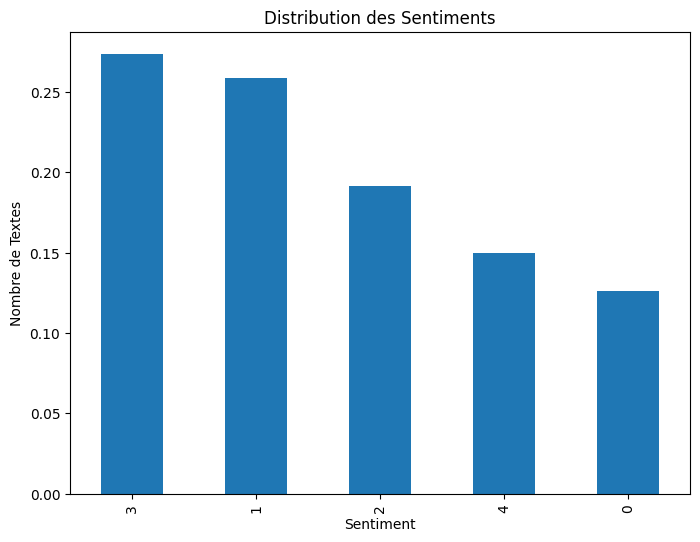

In [126]:
plt.figure(figsize=(8, 6))
df_train_clean['Sentiment'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution des Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de Textes')
plt.show()

In [127]:
# Function to get bigrams or trigrams from a specific sentiment
def get_ngrams(df, sentiment, n=2):
    # Filter the DataFrame by sentiment
    text_data = df[df['Sentiment'] == sentiment]['text_without_stopwords'].dropna()

    # Using CountVectorizer to extract bigrams/trigrams
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text_data)

    # Summing up all occurrences of n-grams
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])))

    return ngram_counts.most_common(10)  # return the top 10 most common n-grams

# Getting bigrams and trigrams for each sentiment
bigrams_by_sentiment = {sentiment: get_ngrams(df_clean, sentiment, n=2) for sentiment in df_clean['Sentiment'].unique()}
trigrams_by_sentiment = {sentiment: get_ngrams(df_clean, sentiment, n=3) for sentiment in df_clean['Sentiment'].unique()}

bigrams_by_sentiment, trigrams_by_sentiment


({np.int64(1): [('lrb rrb', 18),
   ('plays like', 17),
   ('feels like', 15),
   ('running time', 11),
   ('soap opera', 11),
   ('romantic comedy', 9),
   ('film never', 8),
   ('never quite', 8),
   ('movie like', 7),
   ('special effects', 7)],
  np.int64(4): [('one best', 17),
   ('romantic comedy', 11),
   ('one year', 9),
   ('best films', 8),
   ('ever seen', 7),
   ('ever made', 6),
   ('good time', 6),
   ('new york', 6),
   ('year best', 6),
   ('lrb rrb', 5)],
  np.int64(3): [('lrb rrb', 14),
   ('love story', 11),
   ('romantic comedy', 10),
   ('subject matter', 10),
   ('good time', 9),
   ('even though', 7),
   ('character study', 6),
   ('feel like', 6),
   ('feels like', 6),
   ('little film', 6)],
  np.int64(2): [('lrb rrb', 12),
   ('subject matter', 10),
   ('feel like', 6),
   ('cletis tout', 5),
   ('first film', 5),
   ('ice age', 5),
   ('never quite', 5),
   ('plays like', 5),
   ('romantic comedy', 5),
   ('time machine', 5)],
  np.int64(0): [('lrb rrb', 9),


In [128]:
# Preparing data for visualization
def prepare_ngrams_data(ngrams_by_sentiment):
    sentiments = []
    ngram_values = []
    ngram_types = []

    for sentiment, ngrams in ngrams_by_sentiment.items():
        for ngram, count in ngrams:
            sentiments.append(sentiment)
            ngram_values.append(count)
            ngram_types.append(ngram)

    return sentiments, ngram_values, ngram_types

# Prepare data for bigrams and trigrams
bigram_sentiments, bigram_values, bigram_types = prepare_ngrams_data(bigrams_by_sentiment)
trigram_sentiments, trigram_values, trigram_types = prepare_ngrams_data(trigrams_by_sentiment)

# Create bigram bar chart
fig_bigrams = go.Figure(data=[
    go.Bar(name='Bigrams', x=bigram_types, y=bigram_values, text=bigram_sentiments, hovertemplate='Sentiment: %{text}<br>Bigram: %{x}<br>Count: %{y}<extra></extra>')
])

fig_bigrams.update_layout(title_text='Most Frequent Bigrams by Sentiment', xaxis_title='Bigrams', yaxis_title='Frequency')

# Create trigram bar chart
fig_trigrams = go.Figure(data=[
    go.Bar(name='Trigrams', x=trigram_types, y=trigram_values, text=trigram_sentiments, hovertemplate='Sentiment: %{text}<br>Trigram: %{x}<br>Count: %{y}<extra></extra>')
])

fig_trigrams.update_layout(title_text='Most Frequent Trigrams by Sentiment', xaxis_title='Trigrams', yaxis_title='Frequency')

# Displaying the figures
fig_bigrams.show()
fig_trigrams.show()


In [129]:
import pandas as pd
import plotly.graph_objects as go

# Fonction pour préparer les données et créer la heatmap
def plot_heatmap(ngrams_by_sentiment, title):
    # Convertir les données en format utilisable pour une heatmap
    sentiments = []
    ngram_values = []
    ngram_types = []

    for sentiment, ngrams in ngrams_by_sentiment.items():
        for ngram, count in ngrams:
            sentiments.append(sentiment)
            ngram_values.append(count)
            ngram_types.append(ngram)

    heatmap_data = pd.DataFrame({
        'Sentiment': sentiments,
        'Ngram': ngram_types,
        'Count': ngram_values
    })

    # Créer un tableau croisé dynamique pour la heatmap
    heatmap_data_pivot = heatmap_data.pivot_table(index='Ngram', columns='Sentiment', values='Count', fill_value=0)

    # Tracer la heatmap avec Plotly
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data_pivot.values,
        x=heatmap_data_pivot.columns,
        y=heatmap_data_pivot.index,
        colorscale='Viridis'))

    fig.update_layout(
        title=title,
        xaxis_title="Sentiment",
        yaxis_title="N-gram"
    )

    fig.show()


# Fonction pour obtenir des bigrammes ou trigrammes par sentiment
def get_ngrams(df, sentiment, n=2):
    text_data = df[df['Sentiment'] == sentiment]['text_without_stopwords'].dropna()
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text_data)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])))
    return ngram_counts.most_common(10)

# Récupérer les bigrammes et trigrammes pour chaque sentiment
bigrams_by_sentiment = {sentiment: get_ngrams(df_clean, sentiment, n=2) for sentiment in df_clean['Sentiment'].unique()}
trigrams_by_sentiment = {sentiment: get_ngrams(df_clean, sentiment, n=3) for sentiment in df_clean['Sentiment'].unique()}

# Tracer les heatmaps
plot_heatmap(bigrams_by_sentiment, "Heatmap of Bigrams by Sentiment")
plot_heatmap(trigrams_by_sentiment, "Heatmap of Trigrams by Sentiment")


In [130]:
import spacy


# Load Spacy's multilingual model
nlp = spacy.load('en_core_web_sm')

# Function to extract names and surnames using Spacy's NER
def extract_names_with_spacy(df):
    def get_names_from_phrase(phrase):
        doc = nlp(phrase)
        names = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        return names

    # Apply Spacy NER to extract names and surnames
    df['Names'] = df['Phrase'].apply(get_names_from_phrase)

    return df

# Apply the function to extract names and surnames using Spacy
df_with_names = extract_names_with_spacy(df_clean)

# Display a sample of the dataframe with names
df_with_names[['lemmatized_tokens', 'Names']].head()


NameError: name 'spacy' is not defined

In [62]:
df_names_only = df_with_names[df_with_names['Names'].apply(lambda x: len(x) > 0)]

# Display the rows that contain names
df_names_only[['lemmatized_tokens', 'Names']]

NameError: name 'df_with_names' is not defined

In [52]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

df_clean['pos_tags'] = df_clean['lemmatized_tokens'].apply(extract_pos_tags)


/home/vicky/.pyenv/versions/3.10.6/envs/sentiment_analysis/lib/python3.10/site-packages/spacy/util.py:910: UserWarning:

[W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [53]:
# Compter toutes les formes grammaticales (POS) dans l'ensemble du dataset
from collections import Counter

# Fonction pour compter les POS dans tout le dataset
def count_all_pos_tags(df):
    all_pos = Counter()
    for pos_tags in df['pos_tags']:
        all_pos.update(pos_tags)
    return all_pos

# Calculer la fréquence des POS dans tout le dataset
global_pos_counts = count_all_pos_tags(df_clean)


/tmp/ipykernel_31732/1704424568.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




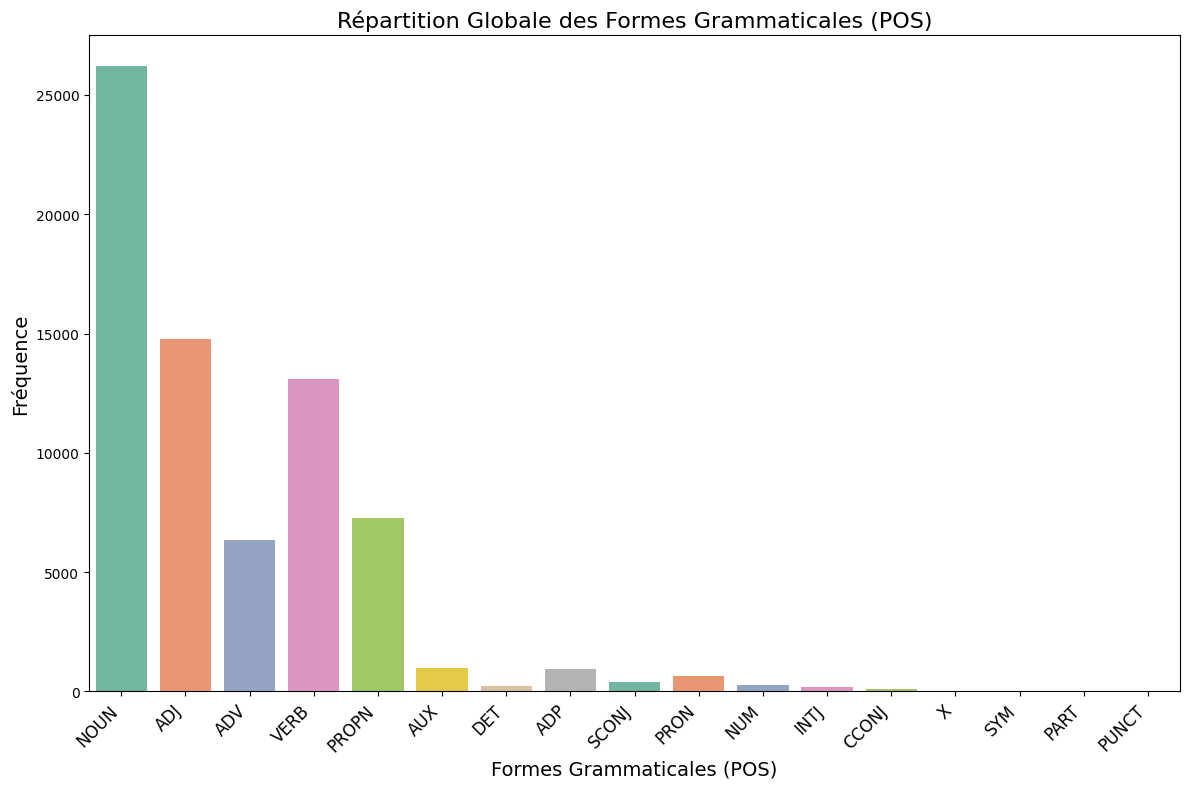

In [55]:
# Créer un DataFrame à partir des comptages POS
global_pos_df = pd.DataFrame.from_dict(global_pos_counts, orient='index', columns=['count']).reset_index()
global_pos_df = global_pos_df.rename(columns={'index': 'POS'})

# Tracer le graphique en barres
plt.figure(figsize=(12, 8))
sns.barplot(x='POS', y='count', data=global_pos_df, palette="Set2")

# Ajouter des étiquettes et un titre
plt.title('Répartition Globale des Formes Grammaticales (POS)', fontsize=16)
plt.xlabel('Formes Grammaticales (POS)', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)

# Afficher le graphique
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()


In [56]:
df_clean

PhraseId  SentenceId  \
0              1           1   
63            64           2   
81            82           3   
116          117           4   
156          157           5   
...          ...         ...   
155984    155985        8540   
155997    155998        8541   
156021    156022        8542   
156031    156032        8543   
156039    156040        8544   

                                                   Phrase  Sentiment  \
0       A series of escapades demonstrating the adage ...          1   
63      This quiet , introspective and entertaining in...          4   
81      Even fans of Ismail Merchant 's work , I suspe...          1   
116     A positively thrilling combination of ethnogra...          3   
156     Aggressive self-glorification and a manipulati...          1   
...                                                   ...        ...   
155984  ... either you 're willing to go with this cla...          2   
155997  Despite these annoyances , the capable Claybur...          2   
156021  -LRB- Tries -RRB- to parody a genre that 's al...          1   
156031  The movie 's downfall is to substitute plot fo...          1   
156039  The film is darkly atmospheric , with Herrmann...          2   

       langue_detectee                                       cleaned_text  \
0                   en  a series of escapades demonstrating the adage ...   
63                  en  this quiet introspective and entertaining inde...   
81                  en  even fans of ismail merchant s work i suspect ...   
116                 en  a positively thrilling combination of ethnogra...   
156                 en  aggressive selfglorification and a manipulativ...   
...                ...                                                ...   
155984              en  either you re willing to go with this claustro...   
155997              en  despite these annoyances the capable clayburgh...   
156021              en  lrb tries rrb to parody a genre that s already...   
156031              en  the movie s downfall is to substitute plot for...   
156039              en  the film is darkly atmospheric with herrmann q...   

                                   text_without_stopwords  \
0       series escapades demonstrating adage good goos...   
63      quiet introspective entertaining independent w...   
81      even fans ismail merchant work suspect would h...   
116     positively thrilling combination ethnography i...   
156     aggressive selfglorification manipulative whit...   
...                                                   ...   
155984              either willing claustrophobic concept   
155997  despite annoyances capable clayburgh tambor re...   
156021  lrb tries rrb parody genre already joke united...   
156031         movie downfall substitute plot personality   
156039  film darkly atmospheric herrmann quietly sugge...   

                                                   tokens  \
0       [series, escapades, demonstrating, adage, good...   
63      [quiet, introspective, entertaining, independe...   
81      [even, fans, ismail, merchant, work, suspect, ...   
116     [positively, thrilling, combination, ethnograp...   
156     [aggressive, selfglorification, manipulative, ...   
...                                                   ...   
155984     [either, willing, go, claustrophobic, concept]   
155997  [despite, annoyances, capable, clayburgh, tamb...   
156021  [, tries, , parody, genre, already, joke, unit...   
156031   [movie, downfall, substitute, plot, personality]   
156039  [film, darkly, atmospheric, herrmann, quietly,...   

                                             stemmed_text  \
0       [seri, escapad, demonstr, adag, good, goos, al...   
63      [quiet, introspect, entertain, independ, worth...   
81      [even, fan, ismail, merchant, work, suspect, w...   
116     [posit, thrill, combin, ethnographi, intrigu, ...   
156             [aggress, selfglorif, manipul, whitewash]   
.

In [57]:
from nltk import FreqDist


In [58]:
# Function to handle and display rare words without replacing them
def display_rare_words(text_series, min_freq=2):
    """
    Identify and display words that appear less than a specified frequency.
    """
    all_words = ' '.join(text_series).split()
    word_freq = FreqDist(all_words)

    # Find words that appear less than `min_freq` times
    rare_words = [word for word, freq in word_freq.items() if freq < min_freq]

    return rare_words

# Apply the function to display rare words in the 'Phrase' column
rare_words_list = display_rare_words(df_clean['lemmatized_tokens'], min_freq=3)

# Display the first 20 rare words for brevity
rare_words_list[:20]


['escapade',
 'gander',
 'amuses',
 'ismail',
 'ethnography',
 'deceit',
 'shakespearean',
 'aggressive',
 'selfglorification',
 'whitewash',
 'rooted',
 'undergoing',
 'midlife',
 'quotation',
 'martialarts',
 'fresnadillo',
 'distort',
 'baseball',
 'bilingual',
 'dizzily']

In [59]:
df_test = df_clean

In [60]:
import plotly.express as px

# Visualisation 1: Répartition des sentiments (positif vs. négatif)
sentiment_count = df_clean['SentimentGroup'].value_counts().reset_index()
sentiment_count.columns = ['SentimentGroup', 'Count']

# Create a pie chart to display sentiment distribution
fig_sentiment_pie = px.pie(sentiment_count, values='Count', names='SentimentGroup',
                           title='Répartition des sentiments (positif vs. négatif)',
                           color_discrete_sequence=px.colors.qualitative.Set2)

fig_sentiment_pie.show()


In [61]:
# Visualisation 2: Scatter plot de la longueur des phrases et de la polarité
fig_length_polarity = px.scatter(df_clean, x='Phrase_length', y='Polarity',
                                 color='SentimentGroup',
                                 title='Relation entre la longueur des phrases et la polarité',
                                 labels={'Phrase_length': 'Longueur des phrases', 'Polarity': 'Polarité'},
                                 color_discrete_sequence=px.colors.qualitative.Set1)

# Display the scatter plot
fig_length_polarity.show()


In [62]:
# Visualisation 3: Scatter plot de la diversité lexicale et de la polarité
fig_diversity_polarity = px.scatter(df_clean, x='diversite_lexical', y='Polarity',
                                    color='SentimentGroup',
                                    title='Diversité lexicale et polarité',
                                    labels={'diversite_lexical': 'Diversité Lexicale', 'Polarity': 'Polarité'},
                                    color_discrete_sequence=px.colors.qualitative.Set3)

# Use ace_tools to display the visualization without connection errors
fig_diversity_polarity.show()

In [63]:
# Visualisation 4: Répartition des sentiments par langue
sentiment_by_lang = df_clean.groupby(['langue_detectee', 'SentimentGroup']).size().reset_index(name='Count')

# Create a bar chart to show sentiment distribution by language
fig_sentiment_lang = px.bar(sentiment_by_lang, x='langue_detectee', y='Count', color='SentimentGroup',
                            title='Répartition des sentiments par langue',
                            labels={'langue_detectee': 'Langue', 'Count': 'Nombre de phrases'},
                            color_discrete_sequence=px.colors.qualitative.Pastel)

# Display using ace_tools
fig_sentiment_lang.show()

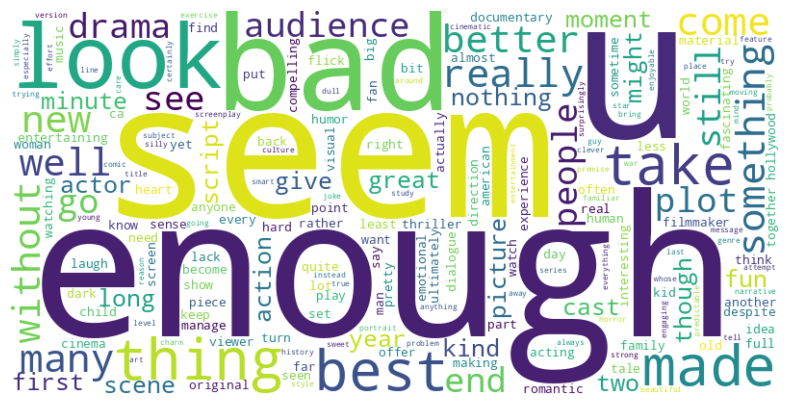

In [64]:
from wordcloud import WordCloud
from collections import Counter

# Extraire la colonne 'lemmatized_tokens'
lemmatized_tokens_list = df_clean['lemmatized_tokens'].dropna().tolist()

# Unir tous les tokens en une seule liste
all_tokens = [token for sublist in lemmatized_tokens_list for token in sublist.split()]

# Compter la fréquence des mots
token_counts = Counter(all_tokens)

# Supprimer les 10 mots les plus fréquents et les 10 mots les moins fréquents
most_common_tokens = [token for token, count in token_counts.most_common(10)]
least_common_tokens = [token for token, count in token_counts.most_common()[-10:]]

# Filtrer les tokens en enlevant les plus fréquents et les moins fréquents
filtered_tokens = [token for token in all_tokens if token not in most_common_tokens and token not in least_common_tokens]

# Générer un texte à partir des tokens filtrés
filtered_text = ' '.join(filtered_tokens)

# Créer le wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Afficher le wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


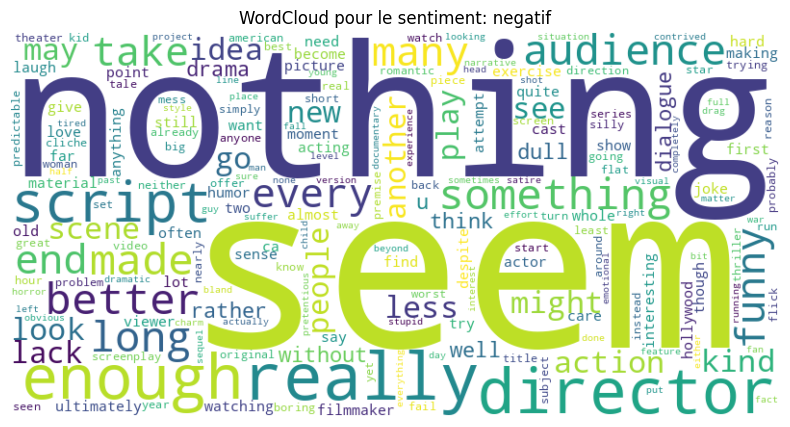

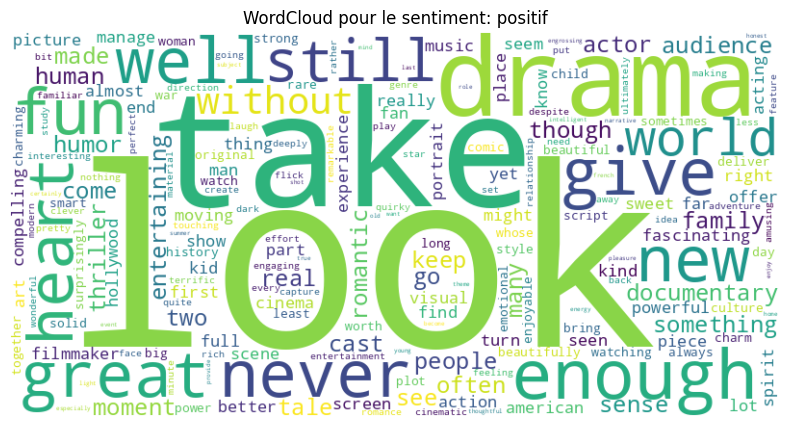

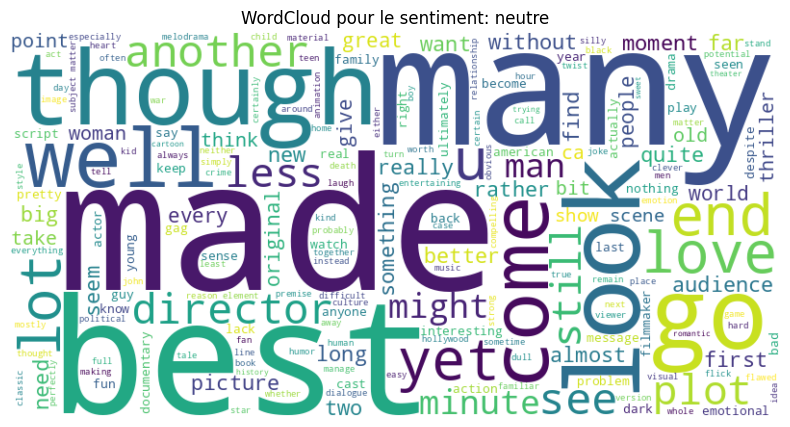

In [65]:
# Créer des WordClouds distincts pour chaque groupe de sentiment (positif, négatif, neutre)
sentiment_groups = df_clean['SentimentGroup'].unique()

# Générer un wordcloud pour chaque groupe de sentiment
for sentiment in sentiment_groups:
    # Filtrer les données par sentiment
    filtered_df = df_clean[df_clean['SentimentGroup'] == sentiment]

    # Extraire les tokens lemmatisés
    lemmatized_tokens_list = filtered_df['lemmatized_tokens'].dropna().tolist()
    all_tokens = [token for sublist in lemmatized_tokens_list for token in sublist.split()]

    # Compter la fréquence des mots
    token_counts = Counter(all_tokens)

    # Supprimer les 10 mots les plus fréquents et les 10 mots les moins fréquents
    most_common_tokens = [token for token, count in token_counts.most_common(10)]
    least_common_tokens = [token for token, count in token_counts.most_common()[-10:]]

    # Filtrer les tokens
    filtered_tokens = [token for token in all_tokens if token not in most_common_tokens and token not in least_common_tokens]

    # Générer le texte filtré
    filtered_text = ' '.join(filtered_tokens)

    # Générer et afficher le WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Afficher le wordcloud avec le titre correspondant au sentiment
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud pour le sentiment: {sentiment}')
    plt.axis('off')
    plt.show()


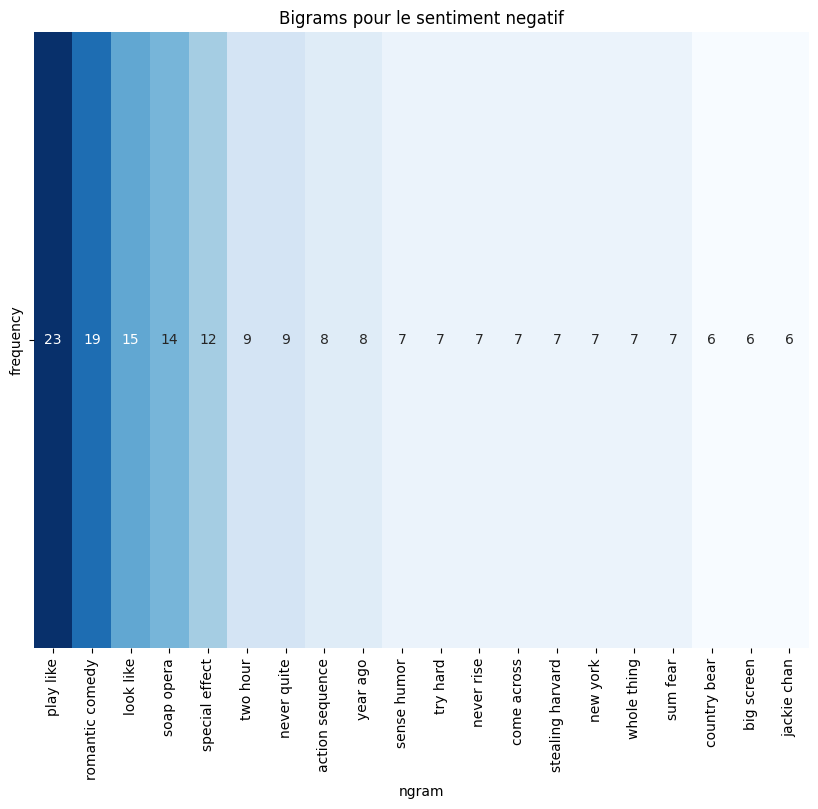

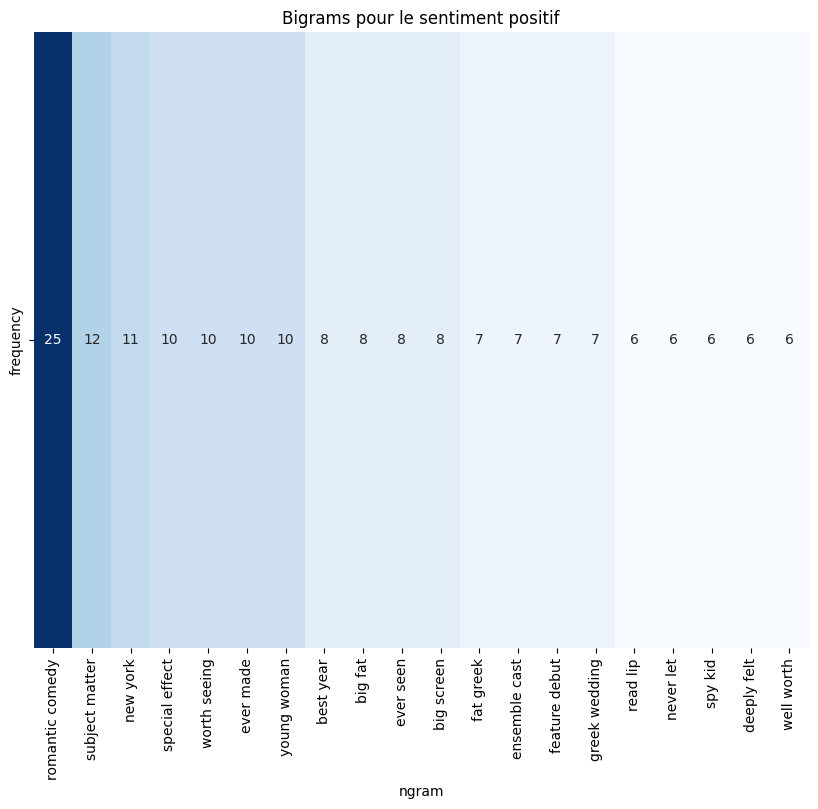

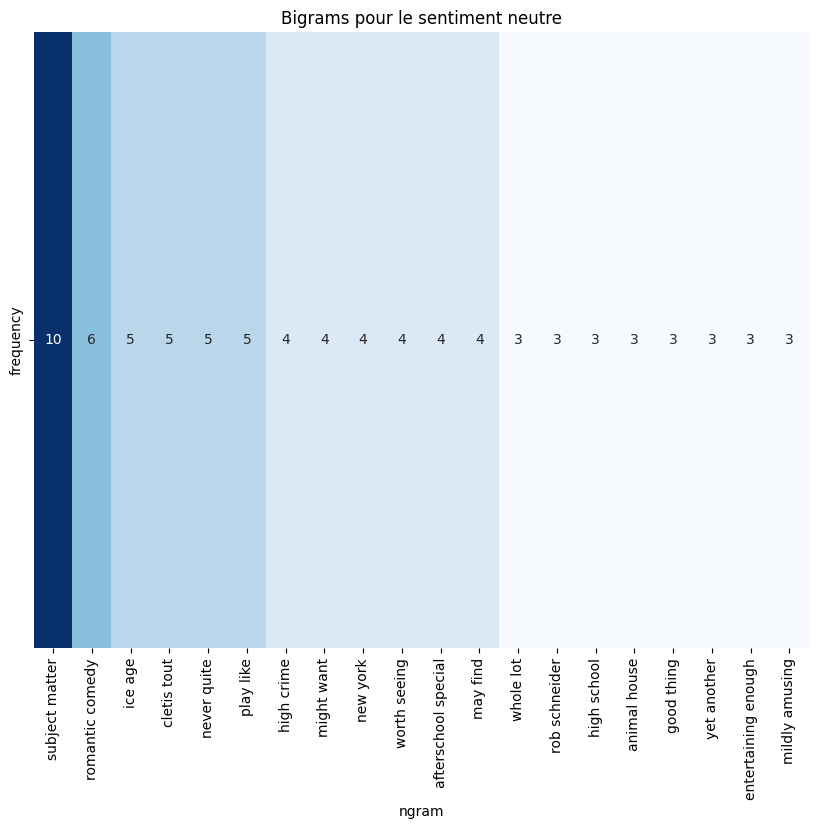

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Fonction pour extraire les bigrams ou trigrams et créer une heatmap
def generate_ngrams_heatmap(df, sentiment, ngram_range, title):
    # Filtrer le DataFrame par groupe de sentiment
    filtered_df = df[df['SentimentGroup'] == sentiment]

    # Extraire les tokens lemmatisés
    lemmatized_text = filtered_df['lemmatized_tokens'].dropna().tolist()

    # Créer une chaîne unique à partir des tokens
    text_data = [' '.join(tokens.split()) for tokens in lemmatized_text]

    # Vectoriser pour extraire les n-grams (bigrams ou trigrams)
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(text_data)

    # Obtenir les fréquences des n-grams
    ngrams_freq = np.asarray(X.sum(axis=0)).flatten()
    ngrams = vectorizer.get_feature_names_out()

    # Créer un DataFrame avec les ngrams et leurs fréquences
    ngrams_df = pd.DataFrame({'ngram': ngrams, 'frequency': ngrams_freq})
    ngrams_df = ngrams_df.sort_values(by='frequency', ascending=False).head(20)  # Top 20

    # Générer une heatmap à partir des ngrams
    plt.figure(figsize=(10, 8))
    sns.heatmap(ngrams_df.set_index('ngram').T, annot=True, cmap="Blues", cbar=False)
    plt.title(f'{title} pour le sentiment {sentiment}')
    plt.show()

# Générer les bigrams pour chaque groupe de sentiment
for sentiment in sentiment_groups:
    generate_ngrams_heatmap(df_clean, sentiment, (2, 2), 'Bigrams')


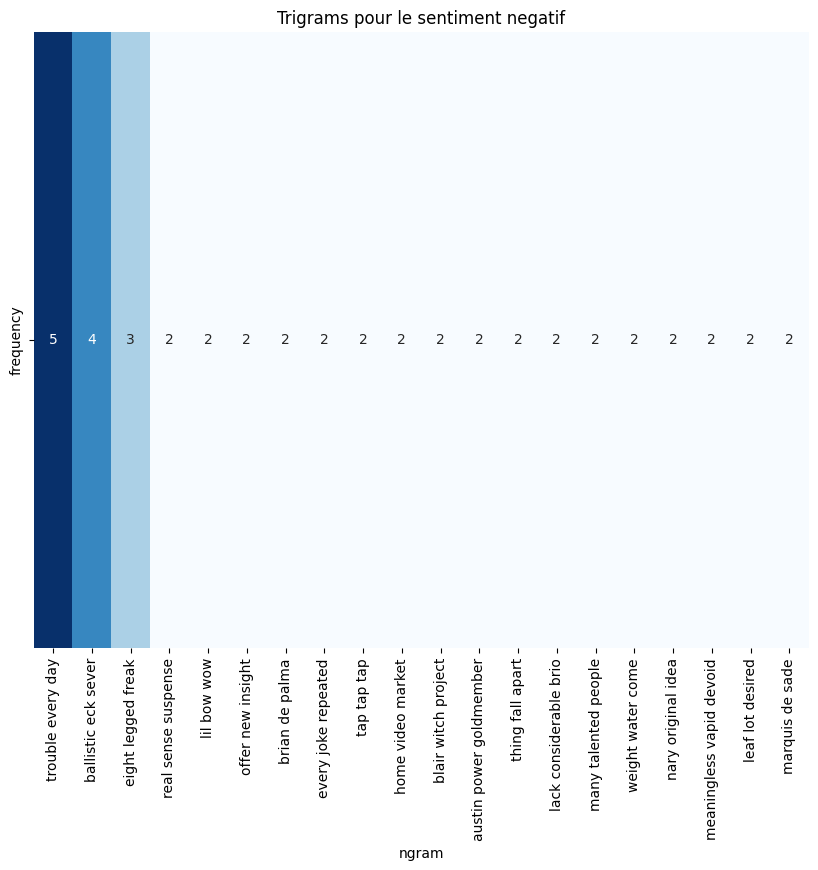

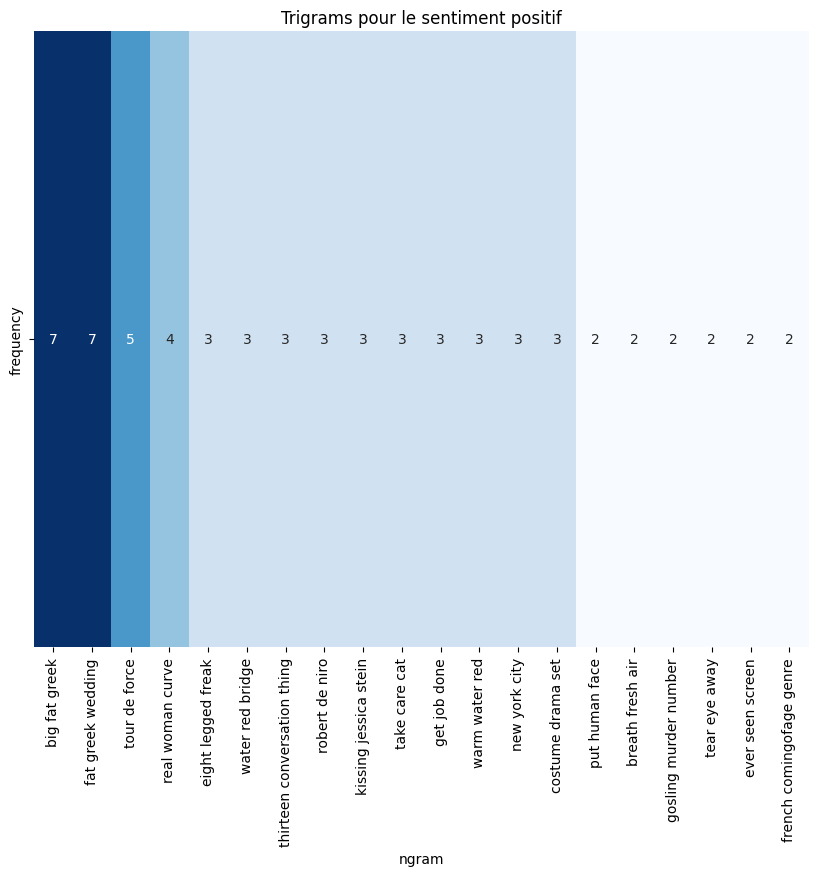

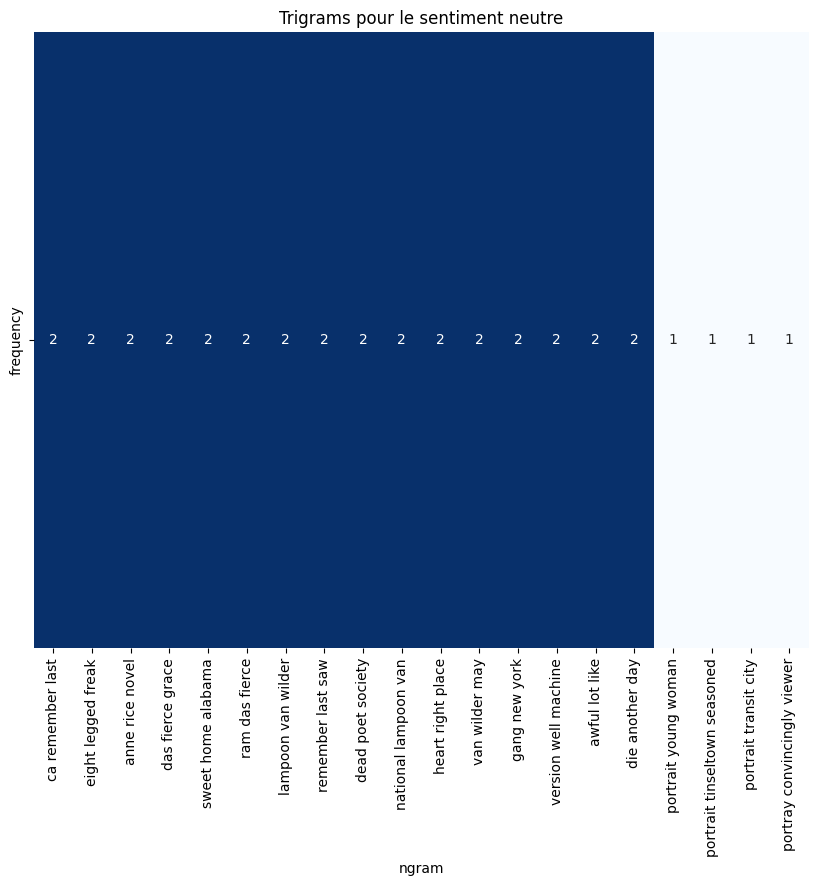

In [67]:
# Générer les trigrams pour chaque groupe de sentiment
for sentiment in sentiment_groups:
    generate_ngrams_heatmap(df_clean, sentiment, (3, 3), 'Trigrams')


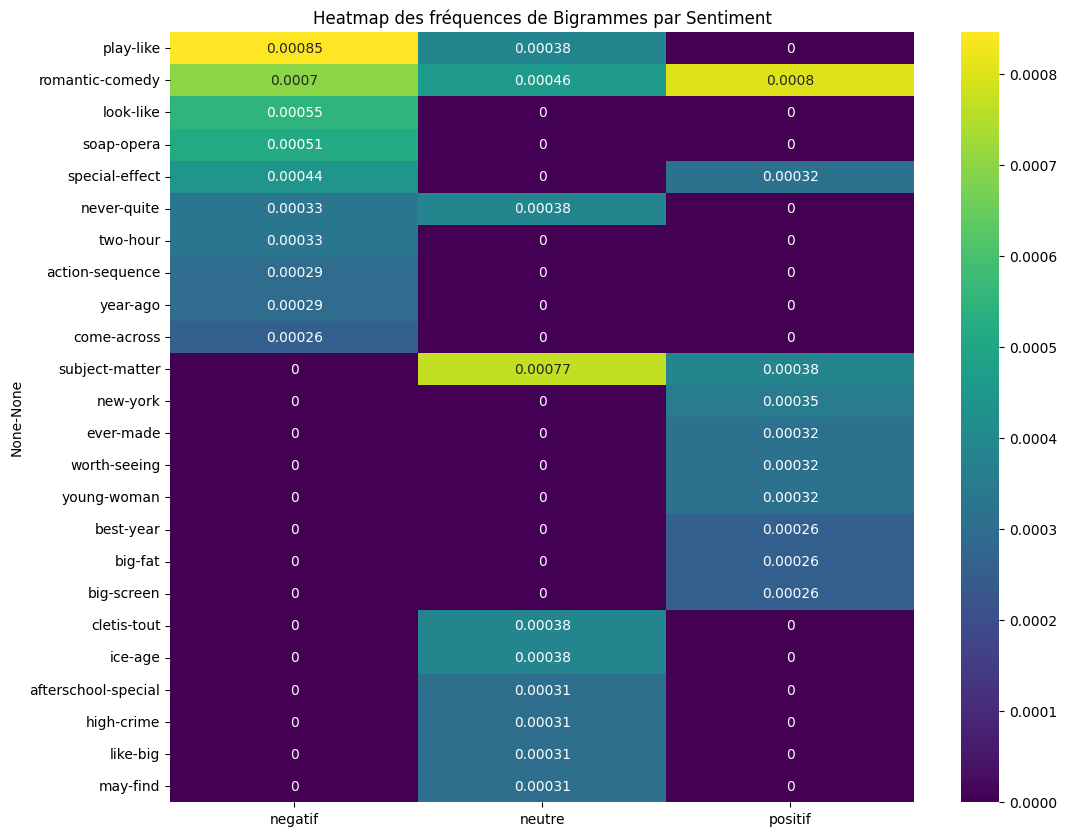

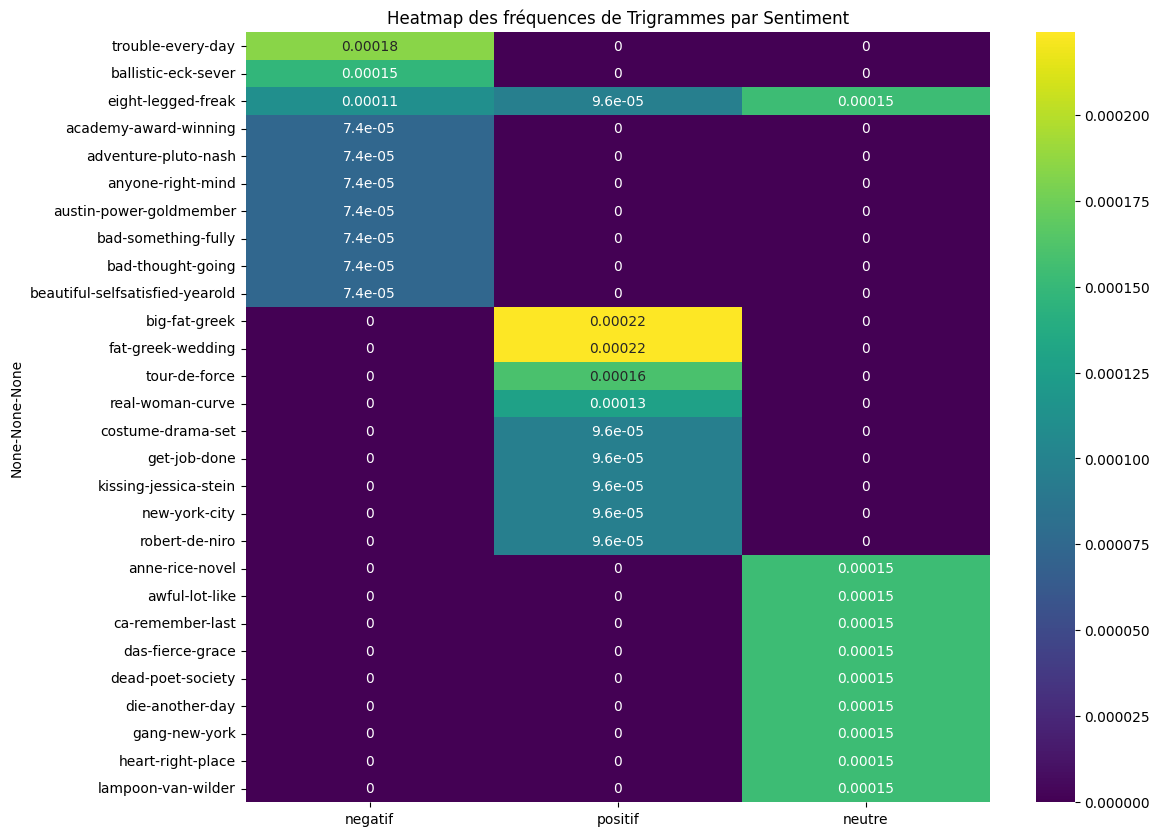

In [68]:
import nltk
from nltk import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

# Fonction pour trouver les bigrammes communs
def common_bigrams(texts):
    words = word_tokenize(" ".join(texts))
    finder = BigramCollocationFinder.from_words(words)
    scored = finder.score_ngrams(BigramAssocMeasures.raw_freq)
    return sorted(scored, key=lambda x: x[1], reverse=True)[:10]

# Fonction pour trouver les trigrammes communs
def common_trigrams(texts):
    words = word_tokenize(" ".join(texts))
    finder = TrigramCollocationFinder.from_words(words)
    scored = finder.score_ngrams(TrigramAssocMeasures.raw_freq)
    return sorted(scored, key=lambda x: x[1], reverse=True)[:10]

# Préparation des données pour les heatmaps
data_bigrams = {}
data_trigrams = {}

# Extraire les bigrammes et trigrammes pour chaque groupe de sentiment
for sentiment in df_clean['SentimentGroup'].unique():
    subset = df_clean[df_clean['SentimentGroup'] == sentiment]['lemmatized_tokens']

    # Convertir en liste de phrases
    subset_texts = subset.dropna().tolist()

    # Trouver les bigrammes et trigrammes communs
    bigrams = common_bigrams(subset_texts)
    trigrams = common_trigrams(subset_texts)

    # Enregistrer les fréquences des bigrammes
    for bigram, freq in bigrams:
        if bigram not in data_bigrams:
            data_bigrams[bigram] = {}
        data_bigrams[bigram][sentiment] = freq

    # Enregistrer les fréquences des trigrammes
    for trigram, freq in trigrams:
        if trigram not in data_trigrams:
            data_trigrams[trigram] = {}
        data_trigrams[trigram][sentiment] = freq

# Convertir en DataFrames
df_bigrams = pd.DataFrame(data_bigrams).fillna(0).T
df_trigrams = pd.DataFrame(data_trigrams).fillna(0).T

# Création des heatmaps
plt.figure(figsize=(12, 10))
sns.heatmap(df_bigrams, annot=True, cmap='viridis')
plt.title('Heatmap des fréquences de Bigrammes par Sentiment')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df_trigrams, annot=True, cmap='viridis')
plt.title('Heatmap des fréquences de Trigrammes par Sentiment')
plt.show()


In [69]:
from gensim.models import Word2Vec

def add_embeddings_column(df, column_name):

    # Assuming 'df_clean' is already loaded
    lemmatized_tokens = df['lemmatized_tokens'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

    # Train the Word2Vec model using the lemmatized tokens
    word2vec_model_updated = Word2Vec(sentences=lemmatized_tokens, vector_size=100, window=5, min_count=1, workers=4)

    def get_sentence_embedding(tokens):
        embeddings = []
        for token in tokens:
            if token in word2vec_model_updated.wv:
                embeddings.append(word2vec_model_updated.wv[token])
        if embeddings:
            return sum(embeddings) / len(embeddings)
        else:
            return None

    # Apply the function to each row
    df['embedding'] = df[column_name].apply(lambda x: get_sentence_embedding(x.strip("[]").replace("'", "").split(", ")))
    return df

# Apply the function to the dataframe
df_with_embeddings = add_embeddings_column(df_clean, 'lemmatized_tokens')

# Display the first few rows of the updated dataframe
df_with_embeddings.head()


PhraseId  SentenceId                                             Phrase  \
0           1           1  A series of escapades demonstrating the adage ...   
63         64           2  This quiet , introspective and entertaining in...   
81         82           3  Even fans of Ismail Merchant 's work , I suspe...   
116       117           4  A positively thrilling combination of ethnogra...   
156       157           5  Aggressive self-glorification and a manipulati...   

     Sentiment langue_detectee  \
0            1              en   
63           4              en   
81           1              en   
116          3              en   
156          1              en   

                                          cleaned_text  \
0    a series of escapades demonstrating the adage ...   
63   this quiet introspective and entertaining inde...   
81   even fans of ismail merchant s work i suspect ...   
116  a positively thrilling combination of ethnogra...   
156  aggressive selfglorification and a manipulativ...   

                                text_without_stopwords  \
0    series escapades demonstrating adage good goos...   
63   quiet introspective entertaining independent w...   
81   even fans ismail merchant work suspect would h...   
116  positively thrilling combination ethnography i...   
156  aggressive selfglorification manipulative whit...   

                                                tokens  \
0    [series, escapades, demonstrating, adage, good...   
63   [quiet, introspective, entertaining, independe...   
81   [even, fans, ismail, merchant, work, suspect, ...   
116  [positively, thrilling, combination, ethnograp...   
156  [aggressive, selfglorification, manipulative, ...   

                                          stemmed_text  \
0    [seri, escapad, demonstr, adag, good, goos, al...   
63   [quiet, introspect, entertain, independ, worth...   
81   [even, fan, ismail, merchant, work, suspect, w...   
116  [posit, thrill, combin, ethnographi, intrigu, ...   
156          [aggress, selfglorif, manipul, whitewash]   

                                     lemmatized_tokens SentimentGroup  \
0    series escapade demonstrating adage good goose...        negatif   
63   quiet introspective entertaining independent w...        positif   
81      fan ismail merchant suspect would hard sitting        negatif   
116  positively thrilling combination ethnography i...        positif   
156  aggressive selfglorification manipulative whit...        negatif   

     Phrase_length  diversite_lexical  Polarity Names  \
0              188           0.923077  0.107692    []   
63              74           1.000000  0.133333    []   
81             100           1.000000 -0.041667    []   
116            152           1.000000  0.036713    []   
156             60           1.000000  0.000000    []   

                                              pos_tags  \
0    [NOUN, NOUN, NOUN, NOUN, ADJ, NOUN, ADV, ADJ, ...   
63                   [ADJ, ADJ, VERB, ADJ, NOUN, VERB]   
81           [PROPN, NOUN, NOUN, NOUN, AUX, ADV, VERB]   
116  [ADV, VERB, NOUN, NOUN, NOUN, PROPN, NOUN, NOU...   
156                             [ADJ, NOUN, ADJ, NOUN]   

                                             embedding  
0    [0.0004243219, 0.008568964, -0.0010559607, -0....  
63   [-0.008932482, 0.009276263, 0.008235575, 0.001...  
81   [0.0006022787, -0.0015754831, 0.0033134865, 0....  
116  [-0.0057835174, -0.0027689314, -0.003407173, -...  
156  [-0.008568334, -0.0062728715, -0.006679014, -0...

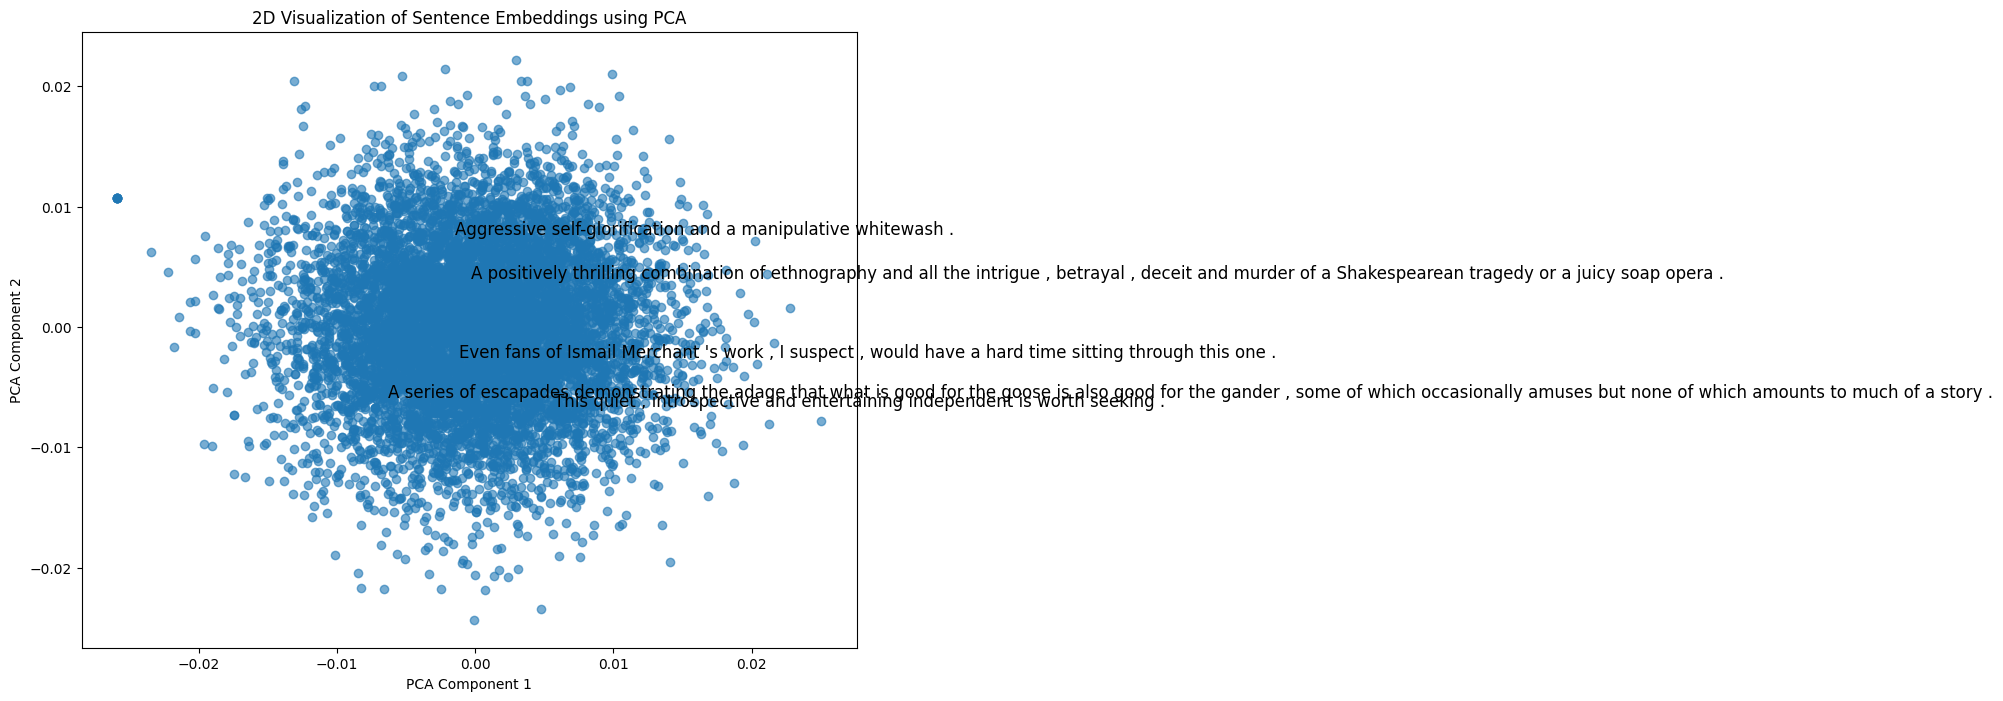

In [70]:
# First, we need to make sure the 'embedding' column from df_clean is extracted properly for PCA
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure that the 'embedding' column is properly formatted (i.e., not containing any missing values)
df_clean_embeddings = df_with_embeddings.dropna(subset=['embedding'])

# Convert the 'embedding' column (which contains lists) into a numpy array format for PCA
embeddings_matrix = np.vstack(df_clean_embeddings['embedding'].values)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

# Create a scatter plot for the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)

# Add some labels for a few points for context
# For simplicity, label the first few points
for i, phrase in enumerate(df_clean_embeddings['Phrase'].values[:5]):  # Limiting to first 5 phrases for readability
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], phrase, fontsize=12)

plt.title('2D Visualization of Sentence Embeddings using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [72]:
embeddings_matrix

array([[ 4.2432189e-04,  8.5689640e-03, -1.0559607e-03, ...,
         7.8339574e-05, -2.4952698e-03,  7.1871700e-03],
       [-8.9324825e-03,  9.2762634e-03,  8.2355747e-03, ...,
        -5.1567410e-03,  1.6314744e-04, -4.2161536e-03],
       [ 6.0227868e-04, -1.5754831e-03,  3.3134865e-03, ...,
        -2.7837991e-03, -6.3854959e-03,  2.7834522e-03],
       ...,
       [-7.0268856e-03, -5.9687137e-04, -3.5620355e-03, ...,
        -9.7625097e-03,  3.6607741e-04, -9.1305878e-03],
       [ 4.5143473e-03, -9.1382978e-04,  4.0164362e-03, ...,
         6.7904606e-03, -4.9552978e-03, -3.3189321e-03],
       [-1.5110135e-03, -4.0345038e-03, -4.3988526e-03, ...,
        -3.4136428e-03, -2.9241275e-03,  5.6689298e-03]], dtype=float32)

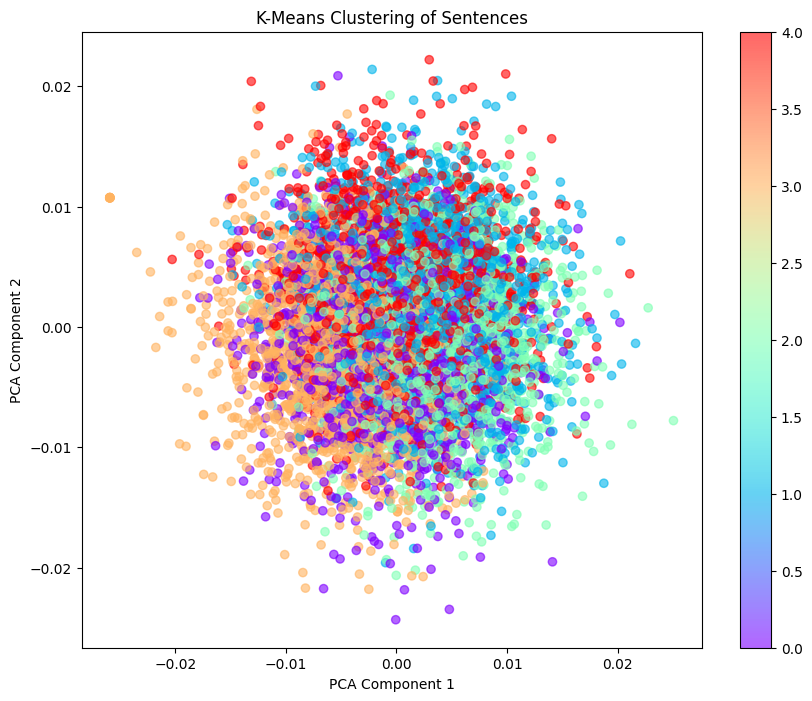

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Number of clusters
k = 5

# Run KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)  # X is the matrix of sentence embeddings

# Add cluster labels to your dataframe
df_clean['Cluster'] = clusters

# Visualize the clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='rainbow', alpha=0.6)
plt.title('K-Means Clustering of Sentences')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [75]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(X)

# Get the most similar sentences for a given sentence (for example, the first sentence)
sentence_idx = 0
similarities = cosine_sim[sentence_idx]

# Sort the sentences by similarity
similar_indices = np.argsort(similarities)[::-1]  # Sorting in descending order

# Print the top 5 most similar sentences
print("Original Sentence:", df_clean.iloc[sentence_idx]['Phrase'])
print("\nMost similar sentences:")
for idx in similar_indices[1:6]:  # Exclude the sentence itself
    print(df_clean.iloc[idx]['Phrase'])


Original Sentence: A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

Most similar sentences:
A negligible British comedy .
If you 're a fan of the series you 'll love it and probably want to see it twice .
A sensitive , modest comic tragedy that works as both character study and symbolic examination of the huge economic changes sweeping modern China .
If there was ever a movie where the upbeat ending feels like a copout , this is the one .
Enormously enjoyable , high-adrenaline documentary .


In [83]:
df_clean.to_csv('sentiment_analysis.csv', index=False)